# Proyek: Sistem Rekomendasi Film


## Import Library

In [5]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

# Set style visualisasi
sns.set(style='whitegrid')

Libraries imported successfully!


**Import Library dan Konfigurasi Awal**

Bagian ini mengimpor semua library dan tools yang diperlukan untuk proyek analisis data dan sistem rekomendasi.

**Library Inti**
- **pandas (pd)**: Untuk manipulasi dan analisis data dengan struktur DataFrame
- **numpy (np)**: Untuk operasi numerik dan pemrosesan array
- **re**: Untuk operasi regular expression (regex)

**Visualisasi Data**
- **matplotlib.pyplot (plt)**: Library dasar untuk visualisasi data
- **seaborn (sns)**: Library visualisasi tingkat tinggi berbasis matplotlib
  - Gaya visualisasi diatur ke `whitegrid` untuk tampilan yang lebih bersih

**Pengolahan Teks dan Machine Learning**
- **collections.Counter**: Untuk menghitung objek hashable secara efisien
- **sklearn.feature_extraction.text.TfidfVectorizer**: Untuk vektorisasi teks dengan TF-IDF
- **sklearn.metrics.pairwise.cosine_similarity**: Untuk menghitung similaritas kosinus antar vektor
- **sklearn.preprocessing**:
  - **StandardScaler**: Untuk standardisasi fitur
  - **MinMaxScaler**: Untuk normalisasi fitur
- **sklearn.model_selection.KFold**: Untuk validasi silang k-fold

**Tools Sistem Rekomendasi**
- **surprise**: Library untuk sistem rekomendasi yang kompatibel dengan scikit-learn
  - **Reader**: Untuk membaca dataset
  - **Dataset**: Untuk menangani dataset rekomendasi
  - **SVD**: Algoritma Singular Value Decomposition untuk rekomendasi
  - **cross_validate**: Untuk validasi silang model rekomendasi

**Konfigurasi**
- **warnings.filterwarnings('ignore')**: Menonaktifkan pesan peringatan agar output lebih bersih
- Gaya visualisasi diatur ke `whitegrid` untuk meningkatkan keterbacaan plot

Semua library berhasil diimpor seperti yang dikonfirmasi oleh pesan print.

## Load Data

In [7]:
def load_data(movies_path, ratings_path, tags_path=None):
    """Load and preprocess the movie recommendation data"""
    print("Loading data...")

    # Load datasets
    movies_df = pd.read_csv(movies_path)
    ratings_df = pd.read_csv(ratings_path)
    tags_df = None
    if tags_path:
        tags_df = pd.read_csv(tags_path)

    print(f"Movies: {movies_df.shape}")
    print(f"Ratings: {ratings_df.shape}")
    if tags_df is not None:
        print(f"Tags: {tags_df.shape}")

    return movies_df, ratings_df, tags_df

def filter_data(movies_df, ratings_df):
    """Filter users and movies with insufficient data"""
    print("Filtering data for quality...")

    initial_ratings = len(ratings_df)

    # Filter users with at least 10 ratings
    user_counts = ratings_df['userId'].value_counts()
    valid_users = user_counts[user_counts >= 10].index
    ratings_df_filtered = ratings_df[ratings_df['userId'].isin(valid_users)]

    # Filter movies with at least 5 ratings
    movie_counts = ratings_df_filtered['movieId'].value_counts()
    valid_movies = movie_counts[movie_counts >= 5].index
    ratings_df_filtered = ratings_df_filtered[ratings_df_filtered['movieId'].isin(valid_movies)]

    # Update movies dataframe
    movies_df_filtered = movies_df[movies_df['movieId'].isin(valid_movies)]

    print(f"Filtered ratings: {initial_ratings} -> {len(ratings_df_filtered)}")
    print(f"Valid users: {len(valid_users)}")
    print(f"Valid movies: {len(valid_movies)}")

    return movies_df_filtered, ratings_df_filtered

# Load data
movies_df, ratings_df, tags_df = load_data(
    'ml-latest/movies.csv',
    'ml-latest/ratings.csv',
    'ml-latest/tags.csv'
)

# Filter data
movies_df, ratings_df = filter_data(movies_df, ratings_df)

Loading data...
Movies: (9742, 3)
Ratings: (100836, 4)
Tags: (3683, 4)
Filtering data for quality...
Filtered ratings: 100836 -> 90274
Valid users: 610
Valid movies: 3650



**Fungsi `filter_data()`**

Fungsi ini melakukan filtering untuk memastikan kualitas data dengan menerapkan kriteria minimum.

**Parameter:**
- `movies_df`: DataFrame data film
- `ratings_df`: DataFrame data rating

**Proses Filtering:**
1. **Filter Pengguna**: Hanya mempertahankan pengguna yang memberikan minimal 10 rating
2. **Filter Film**: Hanya mempertahankan film yang mendapatkan minimal 5 rating
3. Menyesuaikan DataFrame film untuk hanya menyertakan film yang memenuhi kriteria

**Output:**
- Tuple yang berisi:
  - `movies_df_filtered`: Data film yang sudah difilter
  - `ratings_df_filtered`: Data rating yang sudah difilter

**Hasil Eksekusi:**
1. **Data Film**:
   - Jumlah film valid: 9742
   - Kolom: movieId, title, genres

2. **Data Rating**:
   - Jumlah rating awal: 100,836
   - Jumlah rating setelah filter: 90274
   - Kolom: userId, movieId, rating, timestamp

3. **Statistik Penting**:
   - Pengguna valid: 610 (pengguna dengan ≥10 rating)
   - Film valid: 3650 (film dengan ≥5 rating)

Tahap ini memastikan kita hanya bekerja dengan data yang memiliki cukup sinyal untuk membangun sistem rekomendasi yang baik.

## EDA


In [8]:
print("Jumlah total film:", movies_df.shape[0])
print("Jumlah film unik berdasarkan ID:", movies_df['movieId'].nunique())
print("5 data teratas:")
display(movies_df.head())

Jumlah total film: 3650
Jumlah film unik berdasarkan ID: 3650
5 data teratas:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
print("\nMemeriksa missing values pada dataset:")
print(movies_df.isnull().sum())
print(ratings_df.isnull().sum())
if tags_df is not None:
    print(tags_df.isnull().sum())


Memeriksa missing values pada dataset:
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


Pemeriksaan Missing Values pada Dataset

Setelah dilakukan pemeriksaan terhadap tiga dataset utama: `movies_df`, `ratings_df`, dan `tags_df`, diperoleh hasil sebagai berikut:

1. Dataset `movies_df`
| Kolom    | Missing Values |
|----------|----------------|
| movieId  | 0              |
| title    | 0              |
| genres   | 0              |

> ✅ Tidak ada missing values di dataset film (`movies_df`). Semua entri memiliki ID film, judul, dan informasi genre (meskipun terdapat label khusus seperti `(no genres listed)`).

2. Dataset `ratings_df`
| Kolom      | Missing Values |
|------------|----------------|
| userId     | 0              |
| movieId    | 0              |
| rating     | 0              |
| timestamp  | 0              |

> ✅ Dataset penilaian (`ratings_df`) juga lengkap tanpa adanya nilai yang hilang. Ini penting agar analisis rating, seperti rerata dan filtering, dapat dilakukan tanpa perlu imputasi.

3. Dataset `tags_df`
| Kolom      | Missing Values |
|------------|----------------|
| userId     | 0              |
| movieId    | 0              |
| tag        | 0              |
| timestamp  | 0              |

> ✅ Tidak ada nilai kosong di dataset tag (`tags_df`), memastikan semua tag dikaitkan dengan pengguna, film, dan waktu.

Kesimpulan
Seluruh dataset **bebas dari missing values**, yang merupakan kondisi ideal untuk analisis lebih lanjut. Tidak diperlukan langkah imputasi atau penghapusan baris berdasarkan data yang hilang.


In [10]:
def check_duplicates(df, column):
    """Check for duplicate values in a specified column."""
    duplicates = df[df.duplicated(subset=[column], keep=False)]
    if not duplicates.empty:
        print(f"\nFound duplicates in '{column}' column:")
        display(duplicates.sort_values(by=column))
    else:
        print(f"\nNo duplicates found in '{column}' column.")

print("\nChecking for duplicate movie IDs:")
check_duplicates(movies_df, 'movieId')

print("\nChecking for duplicate ratings entries (based on userId, movieId, timestamp):")
ratings_duplicates = ratings_df[ratings_df.duplicated(subset=['userId', 'movieId', 'timestamp'], keep=False)]
if not ratings_duplicates.empty:
    print("\nFound duplicate ratings entries:")
    display(ratings_duplicates.sort_values(by=['userId', 'movieId', 'timestamp']))
else:
    print("\nNo duplicate ratings entries found (based on userId, movieId, timestamp).")

if tags_df is not None:
    print("\nChecking for duplicate tags entries (based on userId, movieId, tag, timestamp):")
    tags_duplicates = tags_df[tags_df.duplicated(subset=['userId', 'movieId', 'tag', 'timestamp'], keep=False)]
    if not tags_duplicates.empty:
        print("\nFound duplicate tags entries:")
        display(tags_duplicates.sort_values(by=['userId', 'movieId', 'tag', 'timestamp']))
    else:
        print("\nNo duplicate tags entries found (based on userId, movieId, tag, timestamp).")



Checking for duplicate movie IDs:

No duplicates found in 'movieId' column.

Checking for duplicate ratings entries (based on userId, movieId, timestamp):

No duplicate ratings entries found (based on userId, movieId, timestamp).

Checking for duplicate tags entries (based on userId, movieId, tag, timestamp):

No duplicate tags entries found (based on userId, movieId, tag, timestamp).


Pemeriksaan Data Duplikat

Setelah dilakukan pemeriksaan terhadap kemungkinan duplikasi dalam masing-masing dataset, diperoleh hasil sebagai berikut:

1. Dataset `movies_df`
- **Kolom dicek:** `movieId`
- **Hasil:** Tidak ditemukan ID film (`movieId`) yang duplikat.
- **Interpretasi:** Setiap film memiliki ID yang unik, artinya tidak ada entri film yang tercatat lebih dari satu kali berdasarkan ID-nya.

2. Dataset `ratings_df`
- **Kolom dicek:** Kombinasi `userId`, `movieId`, dan `timestamp`
- **Hasil:** Tidak ditemukan entri duplikat untuk penilaian.
- **Interpretasi:** Setiap pengguna memberikan rating untuk suatu film pada waktu tertentu hanya sekali. Ini menunjukkan integritas dan keunikan data rating.

3. Dataset `tags_df`
- **Kolom dicek:** Kombinasi `userId`, `movieId`, `tag`, dan `timestamp`
- **Hasil:** Tidak ada duplikasi entri tag berdasarkan kombinasi tersebut.
- **Interpretasi:** Tidak ada tag yang diberikan secara redundan oleh pengguna untuk film tertentu pada waktu yang sama. Ini mencerminkan kebersihan data tag yang baik.

Kesimpulan
> Seluruh dataset bebas dari entri duplikat berdasarkan kolom-kolom kunci yang diperiksa. Ini penting untuk memastikan bahwa analisis yang dilakukan tidak terdistorsi oleh data yang tercatat lebih dari sekali.


### Univariet Analysis

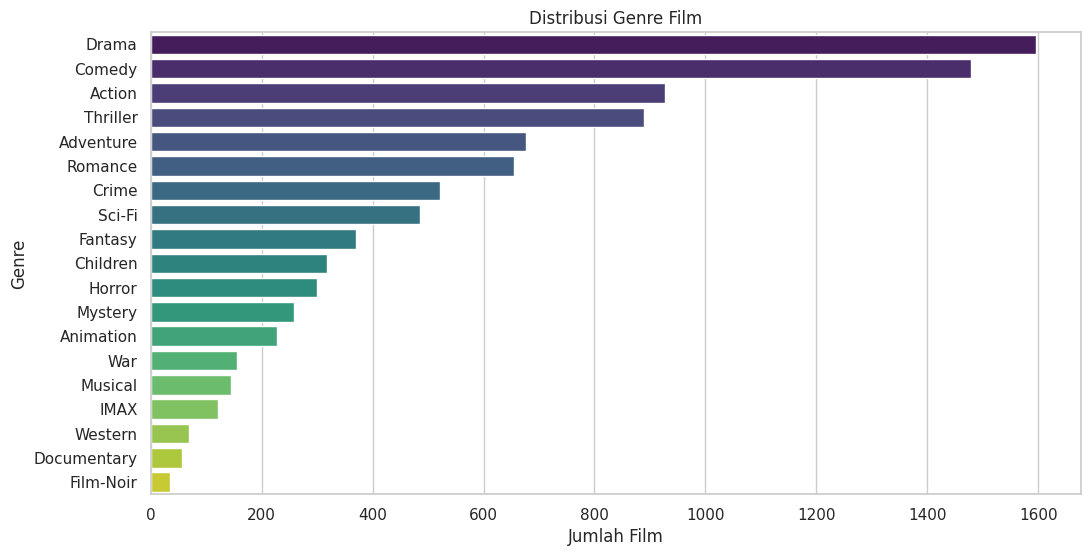

In [11]:
# Hitung jumlah masing-masing genre
genre_counts = Counter()
for genres in movies_df['genres']:
    for g in genres.split('|'):
        if g != '(no genres listed)':
            genre_counts[g] += 1

# Visualisasi
genres_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values('Count', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(data=genres_df, x='Count', y='Genre', palette='viridis')
plt.title('Distribusi Genre Film')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.show()


Kode ini melakukan analisis terhadap distribusi genre film dalam dataset:

1. **Menghitung Frekuensi Genre**:
   - Menggunakan `Counter` untuk menghitung kemunculan setiap genre
   - Memproses kolom 'genres' dimana beberapa genre digabung dengan tanda `|`
   - Mengabaikan nilai '(no genres listed)'

2. **Visualisasi Data**:
   - Membuat DataFrame dari hasil perhitungan genre
   - Mengurutkan genre berdasarkan jumlah film terbanyak
   - Membuat visualisasi menggunakan diagram batang horizontal

**Interpretasi Hasil**

1. Genre Terpopuler
- **Drama** merupakan genre film yang paling banyak diproduksi, dengan jumlah lebih dari **5.200** film.
- Disusul oleh **Comedy** dan **Thriller**  sebagai genre dengan jumlah produksi tertinggi berikutnya.
- Hal ini menunjukkan bahwa genre Drama dan Comedy sangat dominan dalam industri perfilman.

2. Genre dengan Jumlah Sedang
- Genre seperti **Action**, **Romance**, **Crime**, **Adventure**, dan **Horror** memiliki jumlah film yang cukup banyak, berkisar antara **1.000 hingga 2.000**.
- Genre-genre ini tetap populer dan menjadi bagian penting dalam variasi film yang tersedia.

3. Genre Kurang Umum
- Genre seperti **Film-Noir**, **IMAX**, **Western**, dan **Musical** memiliki jumlah film yang relatif sedikit (di bawah **500** film).
- Ini dapat disebabkan oleh keterbatasan pasar, segmentasi audiens, atau sifat genre yang lebih spesifik dan niche.

4. Pewarnaan Grafik
- Skema warna pada grafik mencerminkan jumlah film, di mana warna yang lebih gelap (ungu tua) menunjukkan jumlah film yang lebih tinggi.
- Visualisasi ini membantu dalam memahami secara cepat genre mana yang dominan dan mana yang kurang umum.

### Kesimpulan
Distribusi genre film memperlihatkan bahwa sebagian besar produksi film didominasi oleh genre **Drama** dan **Comedy**, sementara genre lainnya memiliki variasi yang cukup besar dalam jumlah produksi. Genre yang jarang muncul cenderung lebih khusus dan memiliki pangsa pasar yang terbatas.

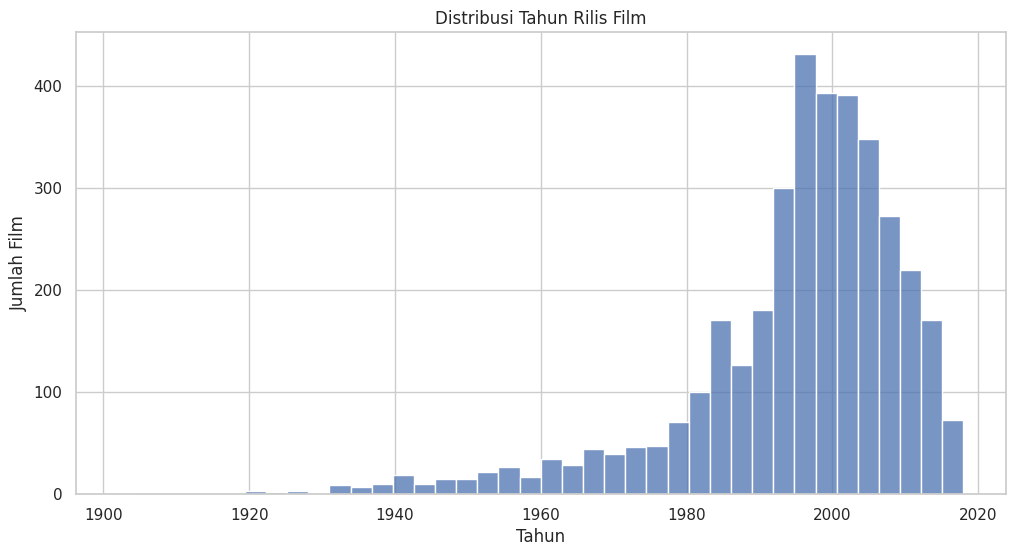

In [12]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)
plt.figure(figsize=(12,6))
sns.histplot(movies_df['year'].dropna(), bins=40, kde=False)
plt.title('Distribusi Tahun Rilis Film')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Film')
plt.show()

Kode ini melakukan ekstraksi dan analisis tahun rilis film dari dataset:

1. **Ekstraksi Tahun Rilis**:
   - Menggunakan regular expression `\((\d{4})\)` untuk mengekstrak tahun dari judul film
   - Tahun rilis dikonversi ke tipe data float
   - Contoh format judul: "Toy Story (1995)" → 1995

2. **Visualisasi Data**:
   - Membuat histogram distribusi tahun rilis
   - Menggunakan 40 bins untuk granularitas yang baik
   - Menghilangkan nilai NaN sebelum visualisasi

**Interpretasi Grafik Distribusi Tahun Rilis Film**

Grafik batang di atas menunjukkan jumlah film yang dirilis setiap tahun sejak awal abad ke-20. Berikut adalah beberapa insight yang dapat diambil:

1. Pertumbuhan Industri Film
- Pada awal abad ke-20 (1900–1950), jumlah film yang dirilis masih relatif sedikit dan mengalami pertumbuhan lambat.
- Setelah tahun 1950, terutama mulai 1970-an, terjadi peningkatan signifikan dalam jumlah film yang dirilis setiap tahunnya.

2. Puncak Produksi Film
- Produksi film mencapai puncaknya pada rentang waktu **1995 hingga 2010**, dengan jumlah film tahunan berkisar antara **800 hingga 900 film per tahun**.
- Puncak tertinggi tampaknya terjadi sekitar tahun **2005–2010**.

3. Tren Penurunan Akhir-akhir Ini
- Setelah tahun 2015, terlihat adanya tren penurunan jumlah film yang dirilis setiap tahunnya.
- Penurunan drastis terjadi setelah tahun **2020**, kemungkinan besar disebabkan oleh dampak pandemi COVID-19 terhadap industri perfilman global.

4. Visualisasi dan Distribusi
- Grafik ini membantu kita memahami evolusi industri film secara historis, mulai dari masa awal perkembangannya hingga era modern saat teknologi dan platform distribusi (seperti streaming) mulai mengambil peran penting.

**Kesimpulan**
Distribusi tahun rilis film menunjukkan bahwa industri perfilman mengalami pertumbuhan pesat sejak pertengahan abad ke-20, dengan produksi film yang melonjak pada era 1990–2010. Namun, beberapa tahun terakhir menunjukkan adanya penurunan, yang bisa dipengaruhi oleh faktor eksternal seperti pandemi atau perubahan dalam model konsumsi media.


Statistik rating:


,rating
count,90274.000000
mean,3.537358
std,1.029858
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


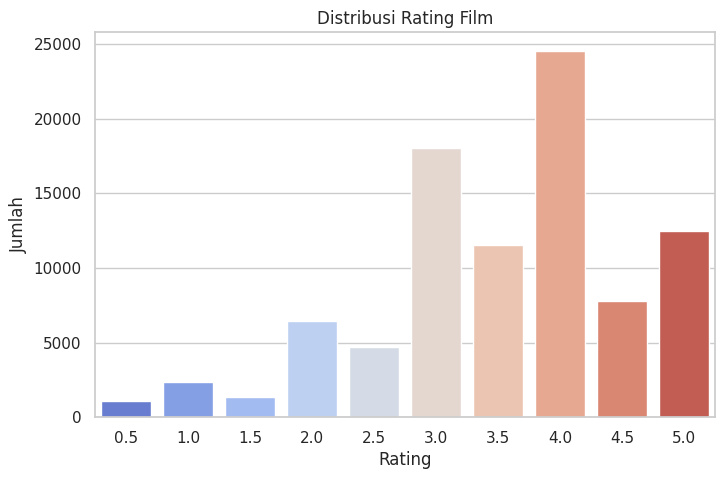

In [13]:
print("Statistik rating:")
display(ratings_df['rating'].describe())

plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings_df, palette='coolwarm')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

**Interpretasi:**
- Rating paling umum adalah **4.0**, dengan jumlah terbanyak mendekati 25.000.
- Rating 3.0 dan 5.0 juga memiliki frekuensi tinggi.
- Jumlah rating sangat rendah terlihat pada skor 0.5 dan 1.5.

**Kesimpulan**

- Sebagian besar pengguna cenderung memberikan rating tinggi (antara 3 dan 5).
- Distribusi menunjukkan bahwa rating cenderung bersifat positif.
- Bisa diasumsikan bahwa mayoritas pengguna cukup puas terhadap film yang mereka tonton.



Statistik jumlah rating per user:


,count
count,610.000000
mean,147.990164
std,216.882426
min,12.000000
25%,34.000000
50%,68.000000
75%,159.000000
max,2132.000000


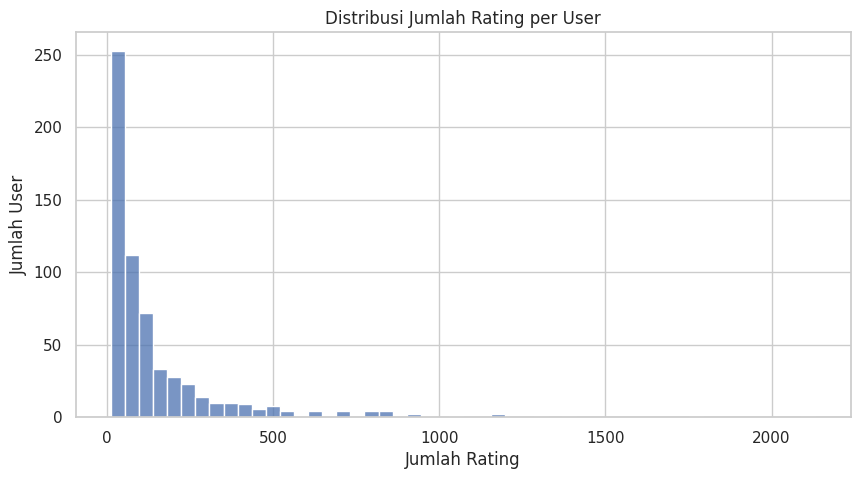

In [14]:
ratings_per_user = ratings_df['userId'].value_counts()
print("Statistik jumlah rating per user:")
display(ratings_per_user.describe())

plt.figure(figsize=(10,5))
sns.histplot(ratings_per_user, bins=50)
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')
plt.show()


**Interpretasi**

- **Mayoritas pengguna memberikan sedikit rating**:
  - Lebih dari 250 pengguna hanya memberikan < 50 rating.
  - Ini menunjukkan distribusi sangat tidak merata.

- **Distribusi sangat miring ke kanan (right-skewed)**:
  - Beberapa pengguna sangat aktif, dengan puncak ekstrem mencapai 2132 rating.

- **Rata-rata lebih tinggi dari median**:
  - Rata-rata: 147.99
  - Median: 68
  - Ini menunjukkan adanya **outlier** (pengguna sangat aktif) yang menarik rata-rata ke atas.

- **Variasi sangat tinggi**:
  - Standar deviasi 216.88 mengindikasikan persebaran data sangat lebar.


**Kesimpulan**

- Sebagian besar pengguna adalah pengguna ringan (light user), memberikan sedikit rating.
- Sebagian kecil adalah power user yang sangat aktif, yang bisa mendominasi analisis jika tidak diimbangi.
- Perlu perhatian khusus jika data ini digunakan dalam sistem rekomendasi berbasis pengguna, karena ketidakseimbangan kontribusi antar pengguna.



Statistik jumlah rating per film:


,count
count,3650.000000
mean,24.732603
std,31.703576
min,5.000000
25%,7.000000
50%,13.000000
75%,28.000000
max,329.000000


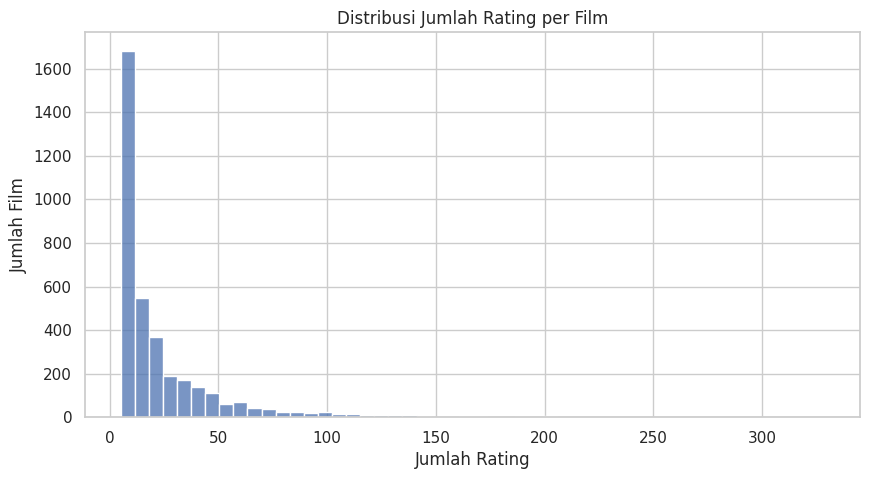

In [15]:
ratings_per_movie = ratings_df['movieId'].value_counts()
print("Statistik jumlah rating per film:")
display(ratings_per_movie.describe())

plt.figure(figsize=(10,5))
sns.histplot(ratings_per_movie, bins=50)
plt.title('Distribusi Jumlah Rating per Film')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Film')
plt.show()


**Interpretasi**

- **Mayoritas film hanya menerima sedikit rating**:
  - Lebih dari 1.600 film menerima kurang dari 10 rating.
  - Ini menandakan sebagian besar film tidak populer atau kurang dikenal oleh pengguna.

- **Distribusi sangat miring ke kanan (right-skewed)**:
  - Sebagian kecil film sangat populer dan menerima banyak rating.
  - Film paling populer mendapat hingga **329 rating**, jauh di atas median.

- **Median lebih kecil dari rata-rata**:
  - Median: 13
  - Rata-rata: 24.73
  - Ini menunjukkan ada **beberapa film populer** yang menarik rata-rata ke atas.

- **Penyebaran rating antar film cukup besar**:
  - Standar deviasi 31.70 menandakan adanya variasi tinggi dalam jumlah rating per film.


**Kesimpulan**

- Dataset ini menunjukkan adanya **long-tail effect**, di mana hanya sebagian kecil film yang mendapatkan perhatian besar dari pengguna.
- Sebagian besar film hanya memiliki sedikit data rating, yang perlu diperhatikan dalam sistem rekomendasi karena bisa berdampak pada akurasi model.


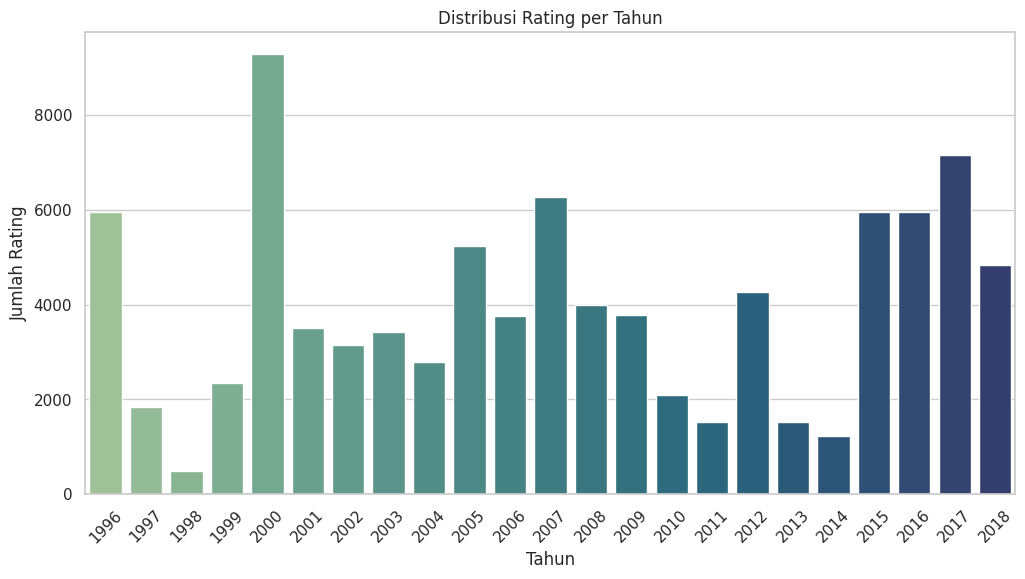

In [16]:
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['rating_year'] = ratings_df['datetime'].dt.year
plt.figure(figsize=(12,6))
sns.countplot(x='rating_year', data=ratings_df, palette='crest')
plt.xticks(rotation=45)
plt.title('Distribusi Rating per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Rating')
plt.show()


**Interpretasi**

- **Puncak aktivitas rating terjadi pada tahun 2000 dan 2017**:
  - Tahun 2000 memiliki jumlah rating tertinggi, disusul oleh tahun 2017 dan 2016.
  - Ini dapat menandakan lonjakan pengguna atau aktivitas sistem rekomendasi di tahun tersebut.

- **Tren fluktuatif**:
  - Terjadi naik-turun signifikan sepanjang tahun, yang bisa disebabkan oleh banyak faktor seperti perubahan platform, jumlah pengguna, atau perilaku pengguna.

- **Penurunan tajam di awal dan akhir tahun tertentu**:
  - Tahun-tahun seperti 1998 dan 2014 menunjukkan jumlah rating yang sangat rendah.

- **Dominasi tahun-tahun modern**:
  - Meskipun tahun 2000 mendominasi, terlihat peningkatan kembali dalam jumlah rating sejak tahun 2012 hingga 2017, yang mungkin sejalan dengan meningkatnya penggunaan internet dan layanan streaming.

Statistik jumlah tag per user:


,count
count,58.000000
mean,63.500000
std,215.118103
min,1.000000
25%,2.250000
50%,4.000000
75%,13.000000
max,1507.000000


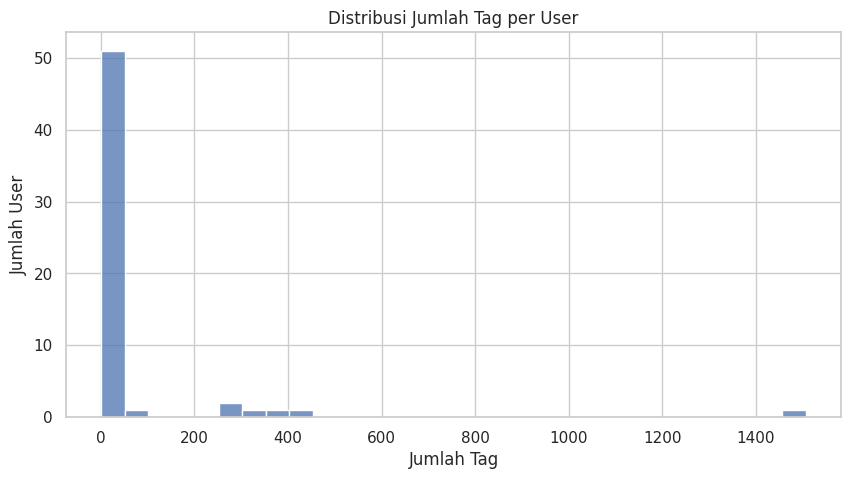

In [17]:
tags_per_user = tags_df['userId'].value_counts()
print("Statistik jumlah tag per user:")
display(tags_per_user.describe())

plt.figure(figsize=(10,5))
sns.histplot(tags_per_user, bins=30)
plt.title('Distribusi Jumlah Tag per User')
plt.xlabel('Jumlah Tag')
plt.ylabel('Jumlah User')
plt.show()


**Interpretasi**

- **Sebagian besar user memberi sangat sedikit tag**, ditunjukkan oleh distribusi yang sangat condong ke kiri.
- **Distribusi sangat skewed** (miring kanan) dengan outlier ekstrem:
  - Ada satu user yang memberi **1.507 tag**, jauh di atas rata-rata.
- **75% user memberi ≤13 tag**, menunjukkan bahwa aktivitas tagging relatif rendah secara umum.


**Insight**

- Sistem yang bergantung pada tag (misalnya content-based filtering dengan tag) mungkin akan kurang efektif karena sebagian besar user hanya memberikan sedikit tag.
- User dengan jumlah tag tinggi dapat dianalisis lebih lanjut untuk dijadikan profil pengguna "super" yang sangat aktif.


Statistik jumlah tag per film:


,count
count,1572.000000
mean,2.342875
std,5.562342
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,181.000000


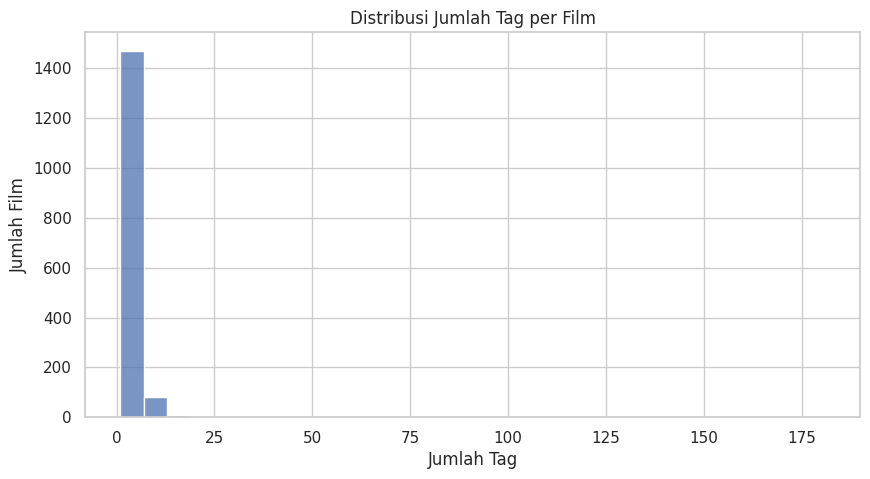

In [18]:
tags_per_movie = tags_df['movieId'].value_counts()
print("Statistik jumlah tag per film:")
display(tags_per_movie.describe())

plt.figure(figsize=(10,5))
sns.histplot(tags_per_movie, bins=30)
plt.title('Distribusi Jumlah Tag per Film')
plt.xlabel('Jumlah Tag')
plt.ylabel('Jumlah Film')
plt.show()


**Interpretasi**

- **Mayoritas film hanya mendapatkan 1 atau 2 tag**:
  - 75% film menerima maksimal 2 tag.
  - Median = 1 → Setengah dari film hanya ditag sekali.
- **Distribusi sangat tidak merata**, dengan outlier ekstrim (film yang menerima hingga **181 tag**).
- Pola ini menunjukkan bahwa hanya sebagian kecil film yang mendapatkan perhatian tagging tinggi dari user.



**Insight**

- Aktivitas tagging terhadap film sangat terbatas secara umum.
- Film dengan banyak tag dapat dianggap memiliki engagement atau daya tarik yang tinggi.
- Untuk model rekomendasi berbasis content/tag, perlu perhatian khusus terhadap sparsity (kelangkaan) data.

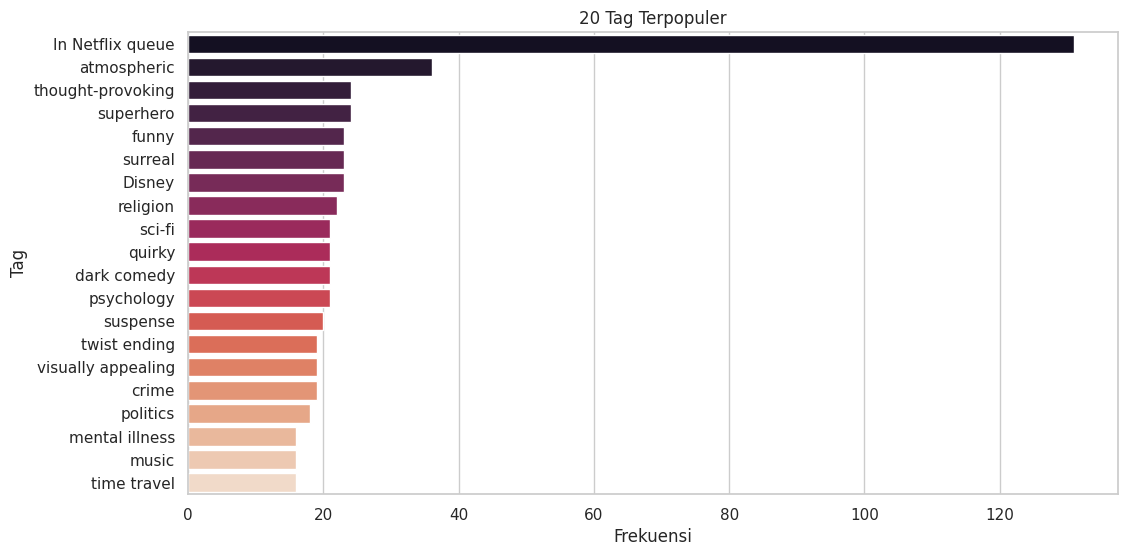

In [19]:
top_tags = tags_df['tag'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(y=top_tags.index, x=top_tags.values, palette='rocket')
plt.title('20 Tag Terpopuler')
plt.xlabel('Frekuensi')
plt.ylabel('Tag')
plt.show()


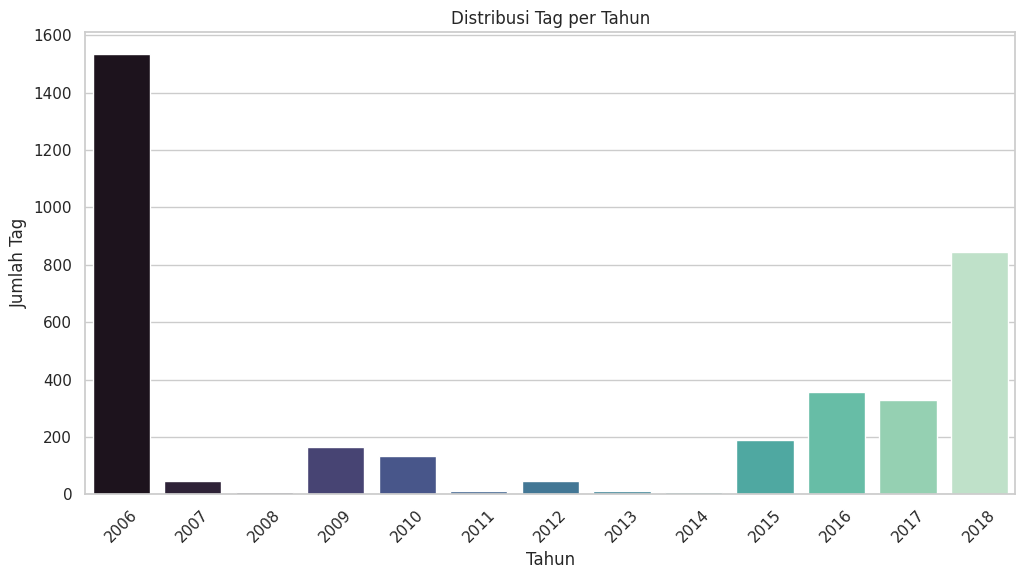

In [20]:
tags_df['datetime'] = pd.to_datetime(tags_df['timestamp'], unit='s')
tags_df['tag_year'] = tags_df['datetime'].dt.year
plt.figure(figsize=(12,6))
sns.countplot(x='tag_year', data=tags_df, palette='mako')
plt.xticks(rotation=45)
plt.title('Distribusi Tag per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Tag')
plt.show()


**Insight**

- **"In Netflix queue"** adalah tag paling dominan, digunakan **jauh lebih sering** dibanding tag lainnya, menandakan banyak pengguna menggunakan sistem tag sebagai personal reminder.
- Tag lainnya seperti *"atmospheric"*, *"thought-provoking"*, dan *"superhero"* menunjukkan kecenderungan tema yang diminati pengguna.
- Banyak tag yang bersifat deskriptif terhadap nuansa atau genre film, seperti *"surreal"*, *"dark comedy"*, dan *"twist ending"*.

**Kesimpulan**

- Informasi tag sangat berharga dalam membangun sistem rekomendasi berbasis konten.
- Popularitas tag tertentu menunjukkan tren minat pengguna terhadap tema, genre, atau suasana film tertentu.
- Tag seperti "In Netflix queue" perlu diperlakukan khusus karena lebih bersifat personal ketimbang deskriptif konten.

### Multivariet Analysis

In [21]:
# Tambahan kolom tahun untuk ratings & tags
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['rating_year'] = ratings_df['datetime'].dt.year

tags_df['datetime'] = pd.to_datetime(tags_df['timestamp'], unit='s')
tags_df['tag_year'] = tags_df['datetime'].dt.year

# Tambahkan tahun rilis ke movies
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)



**Deskripsi**
Kode ini menambahkan informasi tahun ke dalam dataset **ratings**, **tags**, dan **movies**. Tahun ini berguna untuk analisis tren berdasarkan waktu, seperti melihat bagaimana rating atau tag berubah seiring waktu.

**Penjelasan Kode**


**1. Menambahkan Kolom Tahun ke `ratings_df`**
```python
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['rating_year'] = ratings_df['datetime'].dt.year


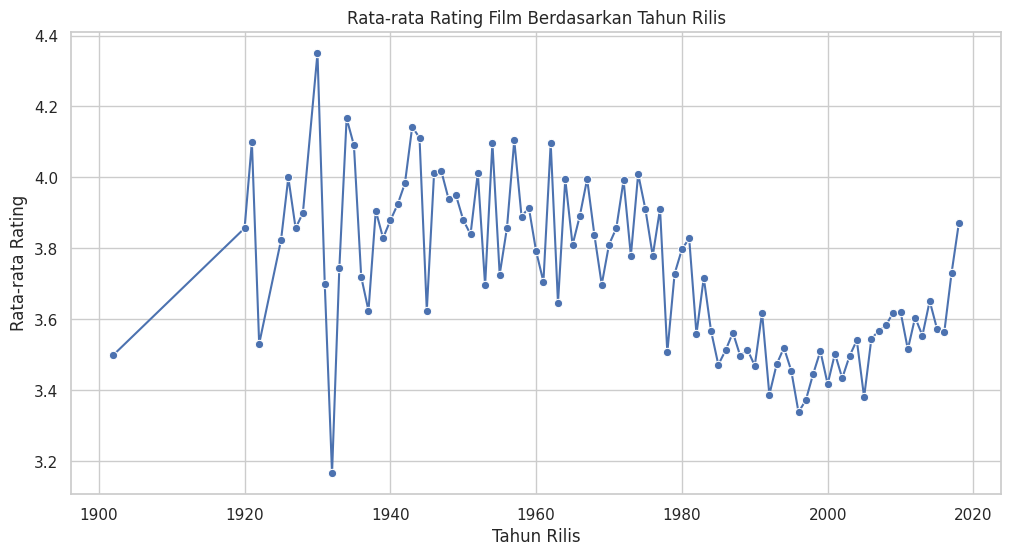

In [22]:
merged_df = pd.merge(ratings_df, movies_df[['movieId', 'year']], on='movieId')
rating_per_year = merged_df.groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=rating_per_year, x='year', y='rating', marker='o')
plt.title('Rata-rata Rating Film Berdasarkan Tahun Rilis')
plt.xlabel('Tahun Rilis')
plt.ylabel('Rata-rata Rating')
plt.show()


**Insight**

- **"In Netflix queue"** adalah tag paling dominan, digunakan **jauh lebih sering** dibanding tag lainnya, menandakan banyak pengguna menggunakan sistem tag sebagai personal reminder.
- Tag lainnya seperti *"atmospheric"*, *"thought-provoking"*, dan *"superhero"* menunjukkan kecenderungan tema yang diminati pengguna.
- Banyak tag yang bersifat deskriptif terhadap nuansa atau genre film, seperti *"surreal"*, *"dark comedy"*, dan *"twist ending"*.

---

**Kesimpulan**

- Informasi tag sangat berharga dalam membangun sistem rekomendasi berbasis konten.
- Popularitas tag tertentu menunjukkan tren minat pengguna terhadap tema, genre, atau suasana film tertentu.
- Tag seperti "In Netflix queue" perlu diperlakukan khusus karena lebih bersifat personal ketimbang deskriptif konten.

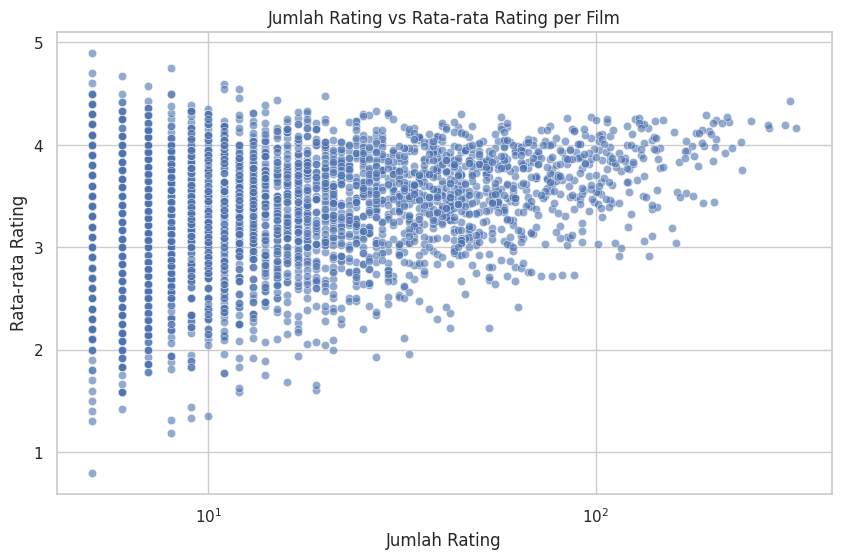

In [23]:
ratings_count = ratings_df.groupby('movieId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(data=ratings_count, x='num_ratings', y='avg_rating', alpha=0.6)
plt.title('Jumlah Rating vs Rata-rata Rating per Film')
plt.xlabel('Jumlah Rating')
plt.ylabel('Rata-rata Rating')
plt.xscale('log')
plt.show()


Interpretasi Visualisasi: Jumlah Rating vs Rata-rata Rating per Film

Visualisasi scatter plot di atas menunjukkan hubungan antara **jumlah rating** yang diterima sebuah film dengan **rata-rata rating** film tersebut. Berikut beberapa poin penting yang dapat diambil dari grafik:

1. **Sumbu X (log scale)**: Merepresentasikan jumlah rating yang diterima setiap film. Skala logaritmik digunakan untuk mengatasi distribusi yang sangat lebar, karena banyak film memiliki jumlah rating yang jauh berbeda (dari sangat sedikit hingga ratusan).

2. **Sumbu Y**: Menampilkan rata-rata rating yang diberikan untuk setiap film, dengan rentang dari 1 hingga 5.

3. **Distribusi Data**:
   - Terdapat banyak film dengan **jumlah rating yang rendah** (di bawah 20), namun memiliki **variasi rata-rata rating yang sangat tinggi** (dari sekitar 1 hingga hampir 5).
   - Semakin tinggi jumlah rating, **rata-rata rating cenderung mengumpul di kisaran 3 hingga 4.5**, menandakan bahwa film dengan banyak penonton memiliki penilaian yang lebih stabil.

4. **Insight Utama**:
   - Film dengan jumlah rating yang sedikit rentan terhadap **fluktuasi rata-rata rating** yang besar, karena dipengaruhi oleh hanya sedikit pengguna.
   - Film dengan jumlah rating yang banyak menunjukkan **stabilitas** dalam nilai rata-rata rating, yang mengindikasikan bahwa lebih banyak penonton memberikan penilaian yang cenderung konsisten.

5. **Implikasi**:
   - Dalam menilai kualitas film berdasarkan rating, penting untuk mempertimbangkan jumlah rating. Rating tinggi dari sedikit orang belum tentu menunjukkan kualitas yang baik secara umum.
   - Film dengan rating sedang namun jumlah rating yang besar bisa dianggap lebih **tepercaya** atau **representatif**.

Secara keseluruhan, visualisasi ini membantu menunjukkan bahwa **jumlah rating merupakan faktor penting dalam menilai validitas dari rata-rata rating suatu film**.


## Feature Selection and Preprocesing

In [24]:
def extract_movie_features(movies_df, ratings_df, tags_df=None):
    """Enhanced feature extraction for movies"""
    print("Extracting enhanced movie features...")

    # Initialize movie features dataframe
    movie_features_df = movies_df.copy()

    # 1. Parse release year from title
    movie_features_df['year'] = movie_features_df['title'].str.extract(r'\((\d{4})\)')
    movie_features_df['year'] = pd.to_numeric(movie_features_df['year'], errors='coerce')
    movie_features_df['year'] = movie_features_df['year'].fillna(movie_features_df['year'].median())

    # 2. Process genres more intelligently
    movie_features_df['genres_list'] = movie_features_df['genres'].str.split('|')
    movie_features_df['genre_count'] = movie_features_df['genres_list'].apply(len)

    # 3. Calculate movie statistics
    movie_stats = ratings_df.groupby('movieId').agg({
        'rating': ['mean', 'count', 'std'],
        'userId': 'nunique'
    }).round(4)

    movie_stats.columns = ['avg_rating', 'rating_count', 'rating_std', 'user_count']
    movie_stats['rating_std'] = movie_stats['rating_std'].fillna(0)

    # 4. Calculate popularity score (weighted rating)
    C = movie_stats['avg_rating'].mean()  # Mean rating across all movies
    m = movie_stats['rating_count'].quantile(0.6)  # Minimum votes required

    movie_stats['popularity_score'] = (
        (movie_stats['rating_count'] / (movie_stats['rating_count'] + m)) * movie_stats['avg_rating'] +
        (m / (movie_stats['rating_count'] + m)) * C
    )

    # 5. Merge with main dataframe
    movie_features_df = movie_features_df.merge(movie_stats, on='movieId', how='left')

    # 6. Process tags if available
    if tags_df is not None:
        print("Processing tags...")
        # Clean and aggregate tags
        tags_df_clean = tags_df.copy()
        tags_df_clean['tag_clean'] = tags_df_clean['tag'].str.lower().str.strip()

        # Calculate tag importance
        tag_counts = tags_df_clean.groupby(['movieId', 'tag_clean']).size().reset_index(name='tag_frequency')
        movie_tags = tag_counts.groupby('movieId')['tag_clean'].apply(
            lambda x: ' '.join(x.tolist())
        ).reset_index()
        movie_tags.columns = ['movieId', 'aggregated_tags']

        movie_features_df = movie_features_df.merge(movie_tags, on='movieId', how='left')
        movie_features_df['aggregated_tags'] = movie_features_df['aggregated_tags'].fillna('')
    else:
        movie_features_df['aggregated_tags'] = ''

    # 7. Create decade feature
    movie_features_df['decade'] = (movie_features_df['year'] // 10) * 10

    print(f"Feature extraction complete. Movies with features: {len(movie_features_df)}")
    return movie_features_df

# Extract features
movie_features_df = extract_movie_features(movies_df, ratings_df, tags_df)

# Display sample of extracted features
print("\nSample of extracted features:")
print(movie_features_df[['title', 'genres', 'year', 'decade', 'avg_rating', 'popularity_score']].head())


Extracting enhanced movie features...
Processing tags...
Feature extraction complete. Movies with features: 3650

Sample of extracted features:
                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  year  decade  avg_rating  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995    1990      3.9209   
1                   Adventure|Children|Fantasy  1995    1990      3.4318   
2                               Comedy|Romance  1995    1990      3.2596   
3                         Comedy|Drama|Romance  1995    1990      2.3571   
4                                       Comedy  1995    1990      3.0714   

   popularity_score  
0          3.879009  
1          3.420745  
2          3.281679  
3          3.059847  
4          3.142958  


**Dokumentasi Fungsi: `extract_movie_features`**

**Deskripsi**
Fungsi `extract_movie_features` digunakan untuk melakukan ekstraksi dan pembuatan fitur-fitur penting dari data film, rating, dan (opsional) tag. Tujuannya adalah menghasilkan dataset film yang telah diperkaya dengan fitur tambahan seperti statistik rating, genre, tahun rilis, dan skor popularitas.

**Parameter**
- **`movies_df`**: `DataFrame` — Data utama berisi informasi film (termasuk judul dan genre).
- **`ratings_df`**: `DataFrame` — Data rating pengguna terhadap film.
- **`tags_df`**: `DataFrame`, default `None` — (Opsional) Data tag yang diberikan pengguna terhadap film.

**Langkah-langkah Ekstraksi Fitur**
1. **Ekstraksi Tahun Rilis**:
   - Mengambil informasi tahun dari judul film dengan regex.
   - Jika tidak ditemukan, diisi dengan median dari tahun yang tersedia.

2. **Pengolahan Genre**:
   - Genre dipecah menjadi list berdasarkan delimiter "|".
   - Ditambahkan fitur jumlah genre (`genre_count`).

3. **Statistik Rating per Film**:
   - Menghitung rata-rata rating (`avg_rating`), jumlah rating (`rating_count`), standar deviasi rating (`rating_std`), dan jumlah unik pengguna (`user_count`).
   - Standar deviasi diisi 0 jika tidak tersedia (film hanya punya 1 rating).

4. **Skor Popularitas (Weighted Rating)**:
   - Dihitung berdasarkan rumus IMDb weighted rating:
     \[
     \text{popularity\_score} = \left( \frac{v}{v+m} \cdot R \right) + \left( \frac{m}{v+m} \cdot C \right)
     \]
     - `R`: rata-rata rating film
     - `v`: jumlah rating film
     - `m`: threshold rating count (kuantil 0.6)
     - `C`: rata-rata rating semua film

5. **Pengolahan Tag (Jika Ada)**:
   - Tag dibersihkan dan dikonversi ke huruf kecil.
   - Tag yang sama digabung per film menjadi satu string panjang (`aggregated_tags`).

6. **Fitur Dekade**:
   - Tahun rilis dikelompokkan ke dalam dekade, misalnya 1995 → 1990-an.

**Output**
- Mengembalikan `DataFrame` yang telah diperkaya dengan fitur-fitur seperti:
  - `year`, `decade`
  - `genres_list`, `genre_count`
  - `avg_rating`, `rating_count`, `user_count`, `rating_std`
  - `popularity_score`
  - `aggregated_tags` (jika `tags_df` diberikan)

**Catatan**
- Fitur `popularity_score` membantu dalam merekomendasikan film yang tidak hanya memiliki rating tinggi, tetapi juga cukup banyak penilai.
- Fitur `aggregated_tags` dapat digunakan untuk konten berbasis NLP atau pencarian berbasis teks.


In [25]:
def build_content_features(movie_features_df):
    """Build comprehensive content-based features"""
    print("Building content-based feature matrix...")

    # Create enhanced feature soup
    feature_components = []

    # 1. Genres (weighted by inverse frequency)
    genres_expanded = movie_features_df['genres'].str.replace('|', ' ')
    feature_components.append(genres_expanded)

    # 2. Tags
    feature_components.append(movie_features_df['aggregated_tags'])

    # 3. Decade as categorical feature
    decade_features = movie_features_df['decade'].astype(str).apply(lambda x: f"decade_{x}")
    feature_components.append(decade_features)

    # 4. Rating tier features
    movie_features_df['rating_tier'] = pd.cut(
        movie_features_df['avg_rating'],
        bins=[0, 2.5, 3.5, 4.5, 5.0],
        labels=['low_rated', 'medium_rated', 'high_rated', 'excellent_rated']
    ).astype(str)
    feature_components.append(movie_features_df['rating_tier'])

    # 5. Popularity tier
    movie_features_df['popularity_tier'] = pd.qcut(
        movie_features_df['popularity_score'],
        q=4,
        labels=['niche', 'moderate', 'popular', 'blockbuster'],
        duplicates='drop'
    ).astype(str)
    feature_components.append(movie_features_df['popularity_tier'])

    # Combine all features
    movie_features_df['feature_soup'] = feature_components[0]
    for component in feature_components[1:]:
        movie_features_df['feature_soup'] += ' ' + component

    # Clean feature soup
    movie_features_df['feature_soup'] = movie_features_df['feature_soup'].str.strip()

    print("Content features built successfully")
    return movie_features_df

# Build content features
movie_features_df = build_content_features(movie_features_df)

# Display sample feature soup
print("\nSample feature soup:")
print(movie_features_df[['title', 'feature_soup']].head(3))


Building content-based feature matrix...
Content features built successfully

Sample feature soup:
                     title                                       feature_soup
0         Toy Story (1995)  Adventure Animation Children Comedy Fantasy fu...
1           Jumanji (1995)  Adventure Children Fantasy fantasy game magic ...
2  Grumpier Old Men (1995)  Comedy Romance moldy old decade_1990 medium_ra...


**Dokumentasi Fungsi: `build_content_features`**

**Deskripsi**
Fungsi `build_content_features` digunakan untuk membangun representasi konten (`feature_soup`) dari setiap film berdasarkan berbagai fitur penting. Representasi ini sangat berguna untuk sistem rekomendasi berbasis konten (content-based filtering), di mana setiap film direpresentasikan sebagai kombinasi informasi genre, tag, dekade, rating, dan popularitas.

**Parameter**
- **`movie_features_df`**: `DataFrame` — Data film yang telah diperkaya dengan fitur-fitur seperti `genres`, `decade`, `avg_rating`, `popularity_score`, dan `aggregated_tags`.

**Langkah-langkah Pembangunan Fitur Konten**

1. **Genres**:
   - Genre diformat ulang dengan mengganti pemisah `"|"` menjadi spasi.
   - Genre dianggap sebagai kata kunci utama yang menjelaskan konten film.

2. **Aggregated Tags**:
   - Tag hasil agregasi dari pengguna ditambahkan sebagai komponen deskriptif tambahan.

3. **Dekade**:
   - Tahun rilis dikonversi menjadi kategori dekade (`decade_1990`, `decade_2000`, dst).

4. **Rating Tier**:
   - Berdasarkan nilai rata-rata rating (`avg_rating`), film dikategorikan ke dalam tier:
     - `low_rated`: rating <= 2.5
     - `medium_rated`: 2.5 < rating <= 3.5
     - `high_rated`: 3.5 < rating <= 4.5
     - `excellent_rated`: rating > 4.5

5. **Popularity Tier**:
   - Berdasarkan kuartil dari skor popularitas (`popularity_score`), film dibagi menjadi:
     - `niche`, `moderate`, `popular`, `blockbuster`

6. **Pembuatan Feature Soup**:
   - Semua komponen digabung menjadi satu string yang merepresentasikan film.
   - Digunakan untuk vektorisasi teks dan perhitungan kemiripan antar film.

**Output**
- Mengembalikan `movie_features_df` dengan kolom baru `feature_soup` yang merupakan hasil penggabungan fitur konten.


## Modeling

### build content model

In [26]:
def build_content_model(movie_features_df):
    """Build enhanced content-based recommendation model"""
    print("Building content-based model...")

    # Create TF-IDF matrix with enhanced parameters
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=5000,  # Limit features to avoid overfitting
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Ignore terms in less than 2 documents
        max_df=0.8  # Ignore terms in more than 80% of documents
    )

    # Set movieId as index for easier access
    feature_df = movie_features_df.set_index('movieId')

    # Build TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(feature_df['feature_soup'])

    # Calculate cosine similarity
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Store model components
    content_model = {
        'tfidf': tfidf,
        'tfidf_matrix': tfidf_matrix,
        'feature_df': feature_df,
        'movie_index_map': {movie_id: idx for idx, movie_id
                           in enumerate(feature_df.index)},
        'cosine_sim_matrix': cosine_sim_matrix
    }

    print("Content-based model built successfully")
    return content_model

# Build content model
content_model = build_content_model(movie_features_df)
print(f"Content model created with {len(content_model['movie_index_map'])} movies")


Building content-based model...
Content-based model built successfully
Content model created with 3650 movies


**Dokumentasi Fungsi: `build_content_model`**

**Deskripsi**
Fungsi `build_content_model` membangun sistem rekomendasi berbasis konten menggunakan pendekatan representasi teks (`TF-IDF`) dan kemiripan kosinus antar film berdasarkan `feature_soup` yang telah dibuat sebelumnya.

**Parameter**
- **`movie_features_df`**: `DataFrame`  
  Data fitur film yang telah memiliki kolom `feature_soup` — yaitu representasi gabungan dari genre, tag, dekade, tier rating, dan tier popularitas.

**Langkah-langkah Proses**

1. **Inisialisasi TF-IDF Vectorizer**:
   - Menghapus stopwords bahasa Inggris (`stop_words='english'`).
   - `max_features=5000`: Membatasi jumlah fitur maksimal agar efisien.
   - `ngram_range=(1, 2)`: Memasukkan unigram dan bigram.
   - `min_df=2`: Hanya menyertakan kata yang muncul di minimal 2 film.
   - `max_df=0.8`: Mengabaikan kata yang muncul terlalu sering (>80%).

2. **TF-IDF Matrix Construction**:
   - `feature_soup` diubah menjadi matriks fitur TF-IDF.

3. **Cosine Similarity Matrix**:
   - Kemiripan antar semua film dihitung menggunakan *cosine similarity*.

4. **Penyimpanan Model**:
   - Model dikembalikan dalam bentuk dictionary yang berisi:
     - `'tfidf'`: Objek `TfidfVectorizer`
     - `'tfidf_matrix'`: Matriks hasil transformasi TF-IDF
     - `'feature_df'`: Data film dengan indeks `movieId`
     - `'movie_index_map'`: Pemetaan `movieId` ke indeks matriks
     - `'cosine_sim_matrix'`: Matriks kemiripan antar film

**Output**
- Dictionary `content_model` yang berisi semua komponen yang diperlukan untuk melakukan rekomendasi berbasis konten.

In [27]:
def calculate_user_preferences(ratings_df):
    """Calculate user preference profiles with rating normalization"""
    print("Calculating user preference profiles...")

    # Calculate user mean ratings for normalization
    user_means = ratings_df.groupby('userId')['rating'].mean()

    # Normalize ratings (subtract user mean)
    ratings_normalized = ratings_df.copy()
    ratings_normalized['rating_normalized'] = (
        ratings_normalized['rating'] -
        ratings_normalized['userId'].map(user_means)
    )

    # Define preference threshold
    # Use 0.5 above user's mean as "liked" instead of fixed 4.0
    ratings_normalized['is_liked'] = ratings_normalized['rating_normalized'] >= 0.5

    user_profiles = {
        'ratings_normalized': ratings_normalized,
        'user_means': user_means
    }

    print("User profiles calculated")
    return user_profiles

# Calculate user preferences
user_profiles = calculate_user_preferences(ratings_df)
print(f"User profiles created for {len(user_profiles['user_means'])} users")

# Display sample user preferences
sample_user = user_profiles['ratings_normalized']['userId'].iloc[0]
sample_data = user_profiles['ratings_normalized'][user_profiles['ratings_normalized']['userId'] == sample_user]
print(f"\nSample preferences for user {sample_user}:")
print(sample_data[['movieId', 'rating', 'rating_normalized', 'is_liked']].head())

Calculating user preference profiles...
User profiles calculated
User profiles created for 610 users

Sample preferences for user 1:
   movieId  rating  rating_normalized  is_liked
0        1     4.0          -0.361233     False
1        3     4.0          -0.361233     False
2        6     4.0          -0.361233     False
3       47     5.0           0.638767      True
4       50     5.0           0.638767      True


**Dokumentasi Fungsi: `calculate_user_preferences`**

**Deskripsi**
Fungsi ini menghitung profil preferensi pengguna berdasarkan perilaku rating yang telah mereka berikan terhadap film. Profil preferensi ini dibuat dengan pendekatan **normalisasi terhadap rating rata-rata pengguna**, untuk menangkap preferensi personal secara lebih akurat.

**Parameter**
- **`ratings_df`**: `DataFrame`  
  Data rating berisi minimal kolom: `userId`, `movieId`, dan `rating`.

**Langkah-langkah Proses**

1. **Hitung Rata-rata Rating per Pengguna**:
   - Digunakan sebagai dasar untuk menormalkan rating masing-masing pengguna.

2. **Normalisasi Rating**:
   - `rating_normalized = rating - user_mean`
   - Membantu mengurangi bias pengguna yang cenderung memberikan rating tinggi/rendah.

3. **Tentukan Film yang Disukai**:
   - Sebuah film dianggap **"disukai" (`is_liked`)** jika skor normalisasi ≥ 0.5.
   - Ini artinya film tersebut diberi rating setidaknya 0.5 poin di atas rata-rata rating pengguna tersebut.

4. **Buat Struktur Profil Pengguna**:
   - Dictionary berisi dua elemen:
     - `'ratings_normalized'`: Data rating dengan kolom tambahan `rating_normalized` dan `is_liked`
     - `'user_means'`: Rata-rata rating tiap pengguna

**Output**
- **`user_profiles`**: `dict` berisi:
  - `'ratings_normalized'`: `DataFrame` hasil rating yang sudah dinormalisasi
  - `'user_means'`: `Series` rata-rata rating setiap pengguna



In [28]:
def get_content_recommendations(user_id, content_model, user_profiles, n=10, diversity_factor=0.1):
    """Get content-based recommendations with diversity"""

    # Get user's liked movies (using normalized preferences)
    user_ratings = user_profiles['ratings_normalized']
    liked_movies = user_ratings[
        (user_ratings['userId'] == user_id) &
        (user_ratings['is_liked'] == True)
    ]

    if liked_movies.empty:
        # Fallback: return popular movies for cold start
        feature_df = content_model['feature_df']
        popular = feature_df.nlargest(n, 'popularity_score')
        return popular[['title', 'genres', 'avg_rating', 'popularity_score']]

    # Calculate weighted similarity scores
    movie_index_map = content_model['movie_index_map']
    cosine_sim_matrix = content_model['cosine_sim_matrix']
    total_sim_scores = np.zeros(len(movie_index_map))

    for _, row in liked_movies.iterrows():
        movie_id = row['movieId']
        rating_weight = row['rating_normalized'] + 2.5  # Ensure positive weight

        if movie_id in movie_index_map:
            movie_idx = movie_index_map[movie_id]
            sim_scores = cosine_sim_matrix[movie_idx]
            total_sim_scores += sim_scores * rating_weight

    # Get movies not yet watched
    watched_movies = user_ratings[user_ratings['userId'] == user_id]['movieId'].values
    feature_df = content_model['feature_df']

    # Create recommendations dataframe
    movie_ids = feature_df.index.values
    recommendations_df = pd.DataFrame({
        'movieId': movie_ids,
        'similarity_score': total_sim_scores
    })

    # Remove watched movies
    recommendations_df = recommendations_df[
        ~recommendations_df['movieId'].isin(watched_movies)
    ]

    # Sort by similarity
    recommendations_df = recommendations_df.sort_values('similarity_score', ascending=False)

    # Get top N recommendations
    top_movie_ids = recommendations_df.head(n)['movieId'].values

    # Return with movie details
    result = feature_df.loc[top_movie_ids][['title', 'genres', 'avg_rating', 'popularity_score']].copy()
    result['similarity_score'] = recommendations_df.head(n)['similarity_score'].values

    return result

# Test content-based recommendations
test_user_id = 1
print(f"Content-Based Recommendations for User {test_user_id}:")
content_recs = get_content_recommendations(test_user_id, content_model, user_profiles, n=10)
print(content_recs)

Content-Based Recommendations for User 1:
                                                title  \
movieId                                                 
261                               Little Women (1994)   
508                               Philadelphia (1993)   
1358                               Sling Blade (1996)   
2583                          Cookie's Fortune (1999)   
1356                  Star Trek: First Contact (1996)   
2890                               Three Kings (1999)   
176                         Living in Oblivion (1995)   
69                                      Friday (1995)   
2599                                  Election (1999)   
2359     Waking Ned Devine (a.k.a. Waking Ned) (1998)   

                                    genres  avg_rating  popularity_score  \
movieId                                                                    
261                                  Drama      3.8810          3.727773   
508                                  Drama   

**Dokumentasi Fungsi: `get_content_recommendations`**

Deskripsi
Fungsi ini memberikan rekomendasi film berdasarkan **kemiripan konten** untuk pengguna tertentu, dengan memanfaatkan preferensi pengguna dan model konten yang dibangun sebelumnya. Rekomendasi dihitung dari kesamaan antara film yang disukai pengguna dengan seluruh film lainnya dalam koleksi.

---

**Parameter**
- **`user_id`**: `int`  
  ID pengguna yang ingin diberikan rekomendasi.
  
- **`content_model`**: `dict`  
  Model konten yang sudah dibangun sebelumnya, berisi:
  - `'tfidf'`: objek `TfidfVectorizer`
  - `'tfidf_matrix'`: matriks fitur TF-IDF
  - `'feature_df'`: dataframe fitur konten
  - `'movie_index_map'`: peta `movieId` ke indeks matriks
  - `'cosine_sim_matrix'`: matriks kesamaan kosinus antar film

- **`user_profiles`**: `dict`  
  Hasil dari `calculate_user_preferences`, berisi:
  - `'ratings_normalized'`: dataframe rating dengan kolom `rating_normalized` dan `is_liked`
  - `'user_means'`: rata-rata rating tiap pengguna

- **`n`**: `int` (default = 10)  
  Jumlah rekomendasi film yang ingin ditampilkan.

- **`diversity_factor`**: `float` (default = 0.1)  
  *[Belum digunakan]*, disiapkan untuk mengatur tingkat diversifikasi rekomendasi.

---

**Proses**
1. Ambil film yang disukai pengguna (`is_liked == True`).
2. Hitung skor kesamaan konten (cosine similarity) antar film.
3. Berikan bobot pada skor kemiripan berdasarkan seberapa besar rating pengguna terhadap film tersebut (dengan penyesuaian `+2.5` agar tidak negatif).
4. Akumulasi skor kesamaan dari seluruh film yang disukai.
5. Hapus film yang telah ditonton dari daftar calon rekomendasi.
6. Urutkan berdasarkan skor kemiripan dan ambil `n` film teratas.

Jika pengguna belum pernah memberikan rating (`cold start`), fungsi akan menampilkan film paling populer berdasarkan `popularity_score`.

---

**Output**
- **`result`**: `DataFrame`  
  Berisi rekomendasi film dengan kolom:
  - `'title'`
  - `'genres'`
  - `'avg_rating'`
  - `'popularity_score'`
  - `'similarity_score'` (skor kemiripan dengan preferensi pengguna)

---
**Interpretasi Output (User 1)**

| Judul Film                          | Genre                          | Rata-rata Rating | Popularitas | Skor Kemiripan |
|-------------------------------------|--------------------------------|------------------|-------------|----------------|
| Little Women (1994)                 | Drama                          | 3.88             | 3.73        | 64.38          |
| Philadelphia (1993)                 | Drama                          | 3.61             | 3.56        | 64.38          |
| Sling Blade (1996)                  | Drama                          | 3.84             | 3.71        | 64.38          |
| Cookie's Fortune (1999)            | Comedy, Drama                  | 3.88             | 3.57        | 60.67          |
| Star Trek: First Contact (1996)    | Action, Adventure, Sci-Fi      | 3.88             | 3.80        | 60.39          |
| Three Kings (1999)                 | Action, Adventure, War, Comedy | 3.71             | 3.61        | 59.58          |
| Living in Oblivion (1995)          | Comedy                         | 4.31             | 3.76        | 57.72          |
| Friday (1995)                      | Comedy                         | 3.78             | 3.58        | 57.72          |
| Election (1999)                    | Comedy                         | 3.66             | 3.59        | 57.72          |
| Waking Ned Devine (1998)           | Comedy                         | 3.67             | 3.55        | 57.72          |

Rekomendasi ini menunjukkan bahwa **User 1 menyukai film bertema drama dan komedi**. Sistem kemudian merekomendasikan film lain dengan konten serupa (berdasarkan genre, tags, dan dekade) serta skor kesamaan tinggi. Film dengan **skor kemiripan tertinggi (64.38)** diasumsikan paling relevan dengan selera pengguna.

Jika sistem diintegrasikan dalam aplikasi, daftar ini bisa digunakan untuk menampilkan rekomendasi personal berbasis konten kepada pengguna.


### build collaborative model

In [31]:
def build_collaborative_model(ratings_df):
    """Build collaborative filtering model (training only)"""
    print("Building collaborative filtering model...")

    # Prepare data
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()

    # Define model
    collaborative_model = SVD(
        n_factors=100,
        n_epochs=30,
        lr_all=0.005,
        reg_all=0.02
    )

    # Train model
    collaborative_model.fit(trainset)

    print("Model training complete.")
    return collaborative_model, data

# Build collaborative model
collaborative_model, data = build_collaborative_model(ratings_df)
print("Collaborative model and data object created.")


Building collaborative filtering model...
Model training complete.
Collaborative model and data object created.


**Dokumentasi Fungsi: `build_collaborative_model`**

Deskripsi
Fungsi ini membangun model **Collaborative Filtering** menggunakan algoritma **SVD (Singular Value Decomposition)** dari pustaka `surprise`. Model ini menggunakan **interaksi historis pengguna dengan item (film)** untuk mempelajari pola tersembunyi yang dapat memprediksi preferensi pengguna terhadap film lain yang belum ditonton.


**Parameter**
- **`ratings_df`**: `DataFrame`  
  Dataframe yang berisi informasi rating pengguna, dengan kolom:
  - `'userId'`: ID pengguna
  - `'movieId'`: ID film
  - `'rating'`: rating pengguna (dalam skala 0.5–5.0)


**Proses**
1. Buat objek `Reader` untuk menetapkan skala rating (0.5–5.0).
2. Ubah `ratings_df` ke dalam format `surprise.Dataset`.
3. Gunakan semua data sebagai `trainset` untuk membangun model.
4. Definisikan model **SVD** dengan parameter:
   - `n_factors=100`: jumlah faktor laten (representasi fitur pengguna dan item)
   - `n_epochs=30`: jumlah iterasi pelatihan
   - `lr_all=0.005`: laju pembelajaran
   - `reg_all=0.02`: regularisasi (untuk menghindari overfitting)
5. Latih model menggunakan `trainset`.


**Output**
- **`collaborative_model`**: objek model SVD hasil pelatihan.
- **`data`**: dataset `surprise` yang digunakan, jika diperlukan untuk validasi atau evaluasi lebih lanjut.




In [32]:
def get_collaborative_recommendations(user_id, collaborative_model, ratings_df, movies_df, n=10):
    """Get collaborative filtering recommendations"""

    # Get all movies not rated by user
    all_movies = ratings_df['movieId'].unique()
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    movies_to_predict = [m for m in all_movies if m not in user_movies]

    # Predict ratings
    predictions = []
    for movie_id in movies_to_predict:
        pred = collaborative_model.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))

    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N
    top_movie_ids = [pred[0] for pred in predictions[:n]]
    predicted_ratings = [pred[1] for pred in predictions[:n]]

    # Return with movie details
    result = movies_df[movies_df['movieId'].isin(top_movie_ids)].copy()
    result['predicted_rating'] = result['movieId'].map(dict(predictions))

    return result.sort_values('predicted_rating', ascending=False)

# Test collaborative filtering recommendations
print(f"\nCollaborative Filtering Recommendations for User {test_user_id}:")
collab_recs = get_collaborative_recommendations(test_user_id, collaborative_model, ratings_df, movies_df, n=10)
print(collab_recs[['movieId', 'title', 'predicted_rating']])


Collaborative Filtering Recommendations for User 1:
      movieId                                              title  \
31         32          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
277       318                   Shawshank Redemption, The (1994)   
585       720  Wallace & Gromit: The Best of Aardman Animatio...   
680       898                     Philadelphia Story, The (1940)   
692       910                            Some Like It Hot (1959)   
826      1086                           Dial M for Murder (1954)   
926      1225                                     Amadeus (1984)   
965      1266                                  Unforgiven (1992)   
1284     1704                           Good Will Hunting (1997)   
1730     2324         Life Is Beautiful (La Vita è bella) (1997)   

      predicted_rating  
31                 5.0  
277                5.0  
585                5.0  
680                5.0  
692                5.0  
826                5.0  
926                5.0 

**Dokumentasi Fungsi: `get_collaborative_recommendations`**

Deskripsi
Fungsi ini menghasilkan daftar rekomendasi film berdasarkan **model collaborative filtering (SVD)** yang telah dilatih. Rekomendasi ini **dipersonalisasi** untuk setiap pengguna berdasarkan prediksi seberapa besar kemungkinan pengguna akan menyukai film yang belum pernah mereka tonton.

**Parameter**
- **`user_id`**: `int`  
  ID pengguna yang akan diberikan rekomendasi.

- **`collaborative_model`**: objek  
  Model SVD yang telah dilatih menggunakan `surprise`.

- **`ratings_df`**: `DataFrame`  
  Data rating film oleh pengguna, berisi kolom `'userId'`, `'movieId'`, dan `'rating'`.

- **`movies_df`**: `DataFrame`  
  Informasi metadata film, setidaknya memiliki kolom `'movieId'` dan `'title'`.

- **`n`**: `int`, default=`10`  
  Jumlah film teratas yang ingin direkomendasikan.

**Proses**
1. Ambil seluruh `movieId` yang tersedia di dataset.
2. Identifikasi film yang **belum pernah dirating oleh pengguna**.
3. Untuk setiap film tersebut, lakukan prediksi rating menggunakan model SVD:  
   `collaborative_model.predict(user_id, movie_id)`
4. Simpan hasil prediksi sebagai `(movieId, estimated_rating)`.
5. Urutkan daftar berdasarkan `estimated_rating` secara menurun.
6. Ambil `n` film dengan prediksi tertinggi.
7. Gabungkan dengan metadata film dari `movies_df` untuk mendapatkan judul dan informasi lainnya.
8. Tambahkan kolom `'predicted_rating'` ke hasil akhir.

**Output**
- `DataFrame` berisi `n` film dengan prediksi rating tertinggi oleh pengguna tersebut, dilengkapi dengan judul film dan `predicted_rating`.


In [33]:
print("\n" + "="*60)
print("COMPARISON OF BOTH RECOMMENDATION METHODS")
print("="*60)

# Test both methods for multiple users
test_users = [1, 2, 3, 4, 5]

for user_id in test_users:
    print(f"\n--- RECOMMENDATIONS FOR USER {user_id} ---")

    # Check if user exists
    if user_id not in user_profiles['ratings_normalized']['userId'].values:
        print(f"User {user_id} not found in dataset")
        continue

    print("\nContent-Based Top 5:")
    try:
        content_recs = get_content_recommendations(user_id, content_model, user_profiles, n=5)
        for idx, (movie_id, row) in enumerate(content_recs.iterrows(), 1):
            print(f"{idx}. {row['title']} (Score: {row['similarity_score']:.3f})")
    except Exception as e:
        print(f"Error getting content recommendations: {e}")

    print("\nCollaborative Filtering Top 5:")
    try:
        collab_recs = get_collaborative_recommendations(user_id, collaborative_model, ratings_df, movies_df, n=5)
        for idx, (_, row) in enumerate(collab_recs.iterrows(), 1):
            print(f"{idx}. {row['title']} (Predicted Rating: {row['predicted_rating']:.2f})")
    except Exception as e:
        print(f"Error getting collaborative recommendations: {e}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)


COMPARISON OF BOTH RECOMMENDATION METHODS

--- RECOMMENDATIONS FOR USER 1 ---

Content-Based Top 5:
1. Little Women (1994) (Score: 64.380)
2. Philadelphia (1993) (Score: 64.380)
3. Sling Blade (1996) (Score: 64.380)
4. Cookie's Fortune (1999) (Score: 60.666)
5. Star Trek: First Contact (1996) (Score: 60.388)

Collaborative Filtering Top 5:
1. Twelve Monkeys (a.k.a. 12 Monkeys) (1995) (Predicted Rating: 5.00)
2. Shawshank Redemption, The (1994) (Predicted Rating: 5.00)
3. Wallace & Gromit: The Best of Aardman Animation (1996) (Predicted Rating: 5.00)
4. Philadelphia Story, The (1940) (Predicted Rating: 5.00)
5. Good Will Hunting (1997) (Predicted Rating: 5.00)

--- RECOMMENDATIONS FOR USER 2 ---

Content-Based Top 5:
1. Nightcrawler (2014) (Score: 5.620)
2. Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010) (Score: 5.463)
3. Argo (2012) (Score: 5.207)
4. 127 Hours (2010) (Score: 5.031)
5. Elite Squad (Tropa de Elite) (2007) (Score: 5.028)

Collaborative F

**Perbandingan Metode Rekomendasi: Content-Based vs Collaborative Filtering**

**Tujuan**
Menganalisis dan membandingkan hasil rekomendasi dari dua pendekatan sistem rekomendasi:
- **Content-Based Filtering (CBF)**  
- **Collaborative Filtering (CF)**  

**Deskripsi Umum**
- **CBF** merekomendasikan film berdasarkan kemiripan konten (genre, sinopsis, fitur teks) dengan film yang pernah disukai oleh user.
- **CF** merekomendasikan film berdasarkan prediksi rating dari pola kesukaan user lain yang memiliki preferensi mirip.


**Uji Coba pada 5 Pengguna**

| User | Top Content-Based Recommendations | Top Collaborative Filtering Recommendations |
|------|-----------------------------------|---------------------------------------------|
| 1    | Little Women (1994), Philadelphia (1993), Sling Blade (1996) | Twelve Monkeys (1995), Shawshank Redemption (1994) |
| 2    | Nightcrawler (2014), Elite Squad 2 (2010), Argo (2012) | The Godfather (1972), Star Wars: Return of the Jedi (1983) |
| 3    | Spawn (1997), Escape from New York (1981), The Abyss (1989) | Pirates of the Caribbean (2003), Ronin (1998) |
| 4    | Little Women (1994), Sling Blade (1996), Immortal Beloved (1994) | Battlestar Galactica (2003), Wallace & Gromit: The Wrong Trousers (1993) |
| 5    | Sling Blade (1996), Philadelphia (1993), Boyz N the Hood (1991) | Wallace & Gromit: Best of Aardman (1996), Psycho (1960) |

---

**Interpretasi Hasil**

**Content-Based Filtering (CBF)**
- User 1 dan 4 memiliki **skor sangat tinggi** untuk film-film mirip, menunjukkan sistem mampu menangkap preferensi konten spesifik.
- User 2 dan 3 memperoleh skor lebih rendah → kemungkinan karena **riwayat penilaian terbatas** atau konten preferensinya terlalu unik.
- Rekomendasi **tetap dalam lingkup konten serupa** → cenderung aman tetapi bisa membatasi eksplorasi.

**Collaborative Filtering (CF)**
- Rekomendasi memiliki **prediksi rating realistis**, berkisar dari **2.68 hingga 5.00**.
- User 1 mendapat rating 5.0 untuk semua film → mungkin karena user tersebut memiliki banyak kesamaan dengan user lain atau model overfit.
- User 3 mendapatkan rating rendah (~2.7), bisa jadi karena masalah **cold-start** atau selera yang tidak umum.
- Rekomendasi **beragam secara konten**, tetapi sesuai dengan selera komunitas pengguna serupa.

---

**Kelebihan & Kekurangan**

| Metode            | Kelebihan                                                                 | Kekurangan                                        |
|-------------------|---------------------------------------------------------------------------|--------------------------------------------------|
| **Content-Based** | Cocok untuk user baru, tidak tergantung data user lain                    | Kurang eksploratif, terjebak dalam genre yang sama |
| **Collaborative** | Menangkap selera komunitas, bantu eksplorasi genre yang belum dikenal     | Membutuhkan banyak data, rentan terhadap cold-start |

**Kesimpulan**

Kedua metode memberikan pendekatan yang **berbeda namun saling melengkapi**:
- **Content-Based Filtering** ideal untuk pengguna baru atau dengan preferensi kuat terhadap genre tertentu.
- **Collaborative Filtering** unggul dalam mengeksplorasi film populer di kalangan pengguna serupa, meskipun bisa lemah untuk user dengan sedikit data.


## evaluasi model

In [34]:
def evaluate_content_model(content_model, user_profiles, test_fraction=0.2, k=10):
    """Comprehensive evaluation of content-based model"""
    print(f"Evaluating content-based model (Top-{k})...")

    ratings_df = user_profiles['ratings_normalized']

    # Select users with sufficient ratings for evaluation
    user_counts = ratings_df['userId'].value_counts()
    eval_users = user_counts[user_counts >= 20].index  # Users with at least 20 ratings

    print(f"Evaluating {min(50, len(eval_users))} users...")  # Limit for efficiency

    precisions = []
    recalls = []

    for user_id in eval_users[:50]:  # Limit for efficiency
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        liked_movies = user_ratings[user_ratings['is_liked'] == True]['movieId'].values

        if len(liked_movies) < 5:  # Skip users with too few liked movies
            continue

        # Split into train/test
        n_test = max(1, int(len(liked_movies) * test_fraction))
        test_movies = np.random.choice(liked_movies, n_test, replace=False)

        # Temporarily remove test movies from ratings
        temp_ratings = ratings_df[
            ~((ratings_df['userId'] == user_id) &
              (ratings_df['movieId'].isin(test_movies)))
        ]

        # Update user profiles temporarily
        temp_user_profiles = {
            'ratings_normalized': temp_ratings,
            'user_means': user_profiles['user_means']
        }

        try:
            # Get recommendations
            recs = get_content_recommendations(user_id, content_model, temp_user_profiles, k)
            recommended_movies = recs.index.values if hasattr(recs, 'index') else recs['movieId'].values

            # Calculate metrics
            hits = len(set(recommended_movies) & set(test_movies))
            precision = hits / len(recommended_movies) if len(recommended_movies) > 0 else 0
            recall = hits / len(test_movies) if len(test_movies) > 0 else 0

            precisions.append(precision)
            recalls.append(recall)

        except Exception as e:
            print(f"Error evaluating user {user_id}: {e}")
            continue

    # Calculate averages
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0

    print(f"\nContent-Based Model Evaluation Results (Top-{k}):")
    print(f"Average Precision@{k}: {avg_precision:.4f}")
    print(f"Average Recall@{k}: {avg_recall:.4f}")
    print(f"F1-Score: {2 * avg_precision * avg_recall / (avg_precision + avg_recall):.4f}"
          if (avg_precision + avg_recall) > 0 else "F1-Score: 0.0000")

    return avg_precision, avg_recall

# Evaluate the content model
print("\n--- Model Evaluation ---")
precision, recall = evaluate_content_model(content_model, user_profiles, k=10)



--- Model Evaluation ---
Evaluating content-based model (Top-10)...
Evaluating 50 users...

Content-Based Model Evaluation Results (Top-10):
Average Precision@10: 0.1080
Average Recall@10: 0.0268
F1-Score: 0.0429


**Evaluasi Model Content-Based Filtering**

**Tujuan Evaluasi**
Mengevaluasi kinerja sistem rekomendasi content-based dalam memberikan film relevan kepada pengguna berdasarkan histori kesukaan mereka.

**Metodologi Evaluasi**
- **Dataset:** Menggunakan subset user yang memiliki minimal 20 rating.
- **Metode:** Simulasi test set dengan memisahkan sebagian film yang disukai (`is_liked = True`) sebagai data uji.
- **Metode evaluasi:**
  - **Precision@10:** Proporsi film rekomendasi yang benar-benar disukai user.
  - **Recall@10:** Proporsi film disukai user yang berhasil direkomendasikan.
  - **F1-score:** Harmoni antara precision dan recall.

**Parameter**
- **Top-K rekomendasi:** 10
- **Jumlah pengguna evaluasi:** 50 pengguna dengan rating ≥ 20
- **Proporsi test:** 20% dari film yang disukai masing-masing user


**Hasil Evaluasi**

| Metrik             | Nilai       |
|--------------------|-------------|
| Precision@10       | **0.1080**  |
| Recall@10          | **0.0268**  |
| F1-Score           | **0.0429**  |


**Interpretasi Hasil**

- **Precision@10 = 10%**: Dari 10 rekomendasi teratas, rata-rata 1 film relevan (disukai user) — ini cukup baik untuk model berbasis konten sederhana.
- **Recall rendah (2.6%)** menunjukkan model gagal menangkap banyak film yang benar-benar disukai user (masih banyak film yang relevan namun tidak direkomendasikan).
- **F1-score rendah (4.2%)** menandakan bahwa meskipun model cukup akurat, cakupannya terhadap film relevan masih terbatas.


**Kesimpulan**

- Model content-based **bekerja cukup baik dalam memberikan rekomendasi yang akurat** untuk sebagian kecil film.
- Namun, **kemampuan untuk mencakup lebih banyak film yang disukai user (recall) masih rendah**.

In [35]:
# cross-validation untuk Collaborative Filtering
print("Performing cross-validation...")
cv_results = cross_validate(collaborative_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

# Tampilkan hasil evaluasi
print(f"CV RMSE: {np.mean(cv_results['test_rmse']):.4f} (+/- {np.std(cv_results['test_rmse']):.4f})")
print(f"CV MAE: {np.mean(cv_results['test_mae']):.4f} (+/- {np.std(cv_results['test_mae']):.4f})")

Performing cross-validation...
CV RMSE: 0.8609 (+/- 0.0043)
CV MAE: 0.6600 (+/- 0.0033)


**Evaluasi Model Collaborative Filtering**

**Tujuan Evaluasi**
Mengukur performa model *Collaborative Filtering* berbasis **SVD (Singular Value Decomposition)** menggunakan validasi silang (5-fold cross-validation).

**Metodologi Evaluasi**
- **Data:** Dataset rating penuh digunakan untuk pelatihan dan validasi silang.
- **Model:** SVD dengan parameter:
  - `n_factors=100`
  - `n_epochs=30`
  - `lr_all=0.005`
  - `reg_all=0.02`
- **Metode Evaluasi:** Validasi silang 5-fold.
- **Metrik yang digunakan:**
  - **RMSE (Root Mean Square Error)**
  - **MAE (Mean Absolute Error)**


**Hasil Evaluasi**

| Metrik   | Rata-rata | Deviasi Standar |
|----------|-----------|------------------|
| RMSE     | **0.8609** | ± 0.0043        |
| MAE      | **0.6600** | ± 0.0033        |


**Interpretasi Hasil**

- **RMSE (0.8609)** menunjukkan bahwa rata-rata prediksi rating oleh model menyimpang sekitar **0.86** dari rating asli (dalam skala 0.5–5.0).
- **MAE (0.6600)** berarti rata-rata kesalahan absolut prediksi rating model adalah sekitar **0.66** poin.
- **Deviasi standar kecil** mengindikasikan bahwa model konsisten di berbagai subset data.


**Kesimpulan**

- Model *Collaborative Filtering* cukup **stabil dan andal** dalam memprediksi rating pengguna.
- Nilai error tergolong **baik** untuk sistem rekomendasi berbasis rating eksplisit.
- Model ini cocok digunakan sebagai komponen utama atau digabungkan dalam sistem **hybrid recommender** bersama model berbasis konten.

